## Brief Introduction

There are multiple types of generative models

1. GANs
2. VAEs
3. Flow-based generative models
    

    
    

GANs and VAEs can perform pretty well in modeling the high dimensional distribution such as images. However, they have many limitations. Several of them are listed below:

1. Neither of them allows us to compute the exact probability density of new data.
2. Training of GANs can be challenge due to issues such as mode collapse, instability.

### Normalizing Flows

A Normalizing Flow (NF) is composed of a series of invertible transformation. In comparison with GANs and VAEs, NFs can not only perform generative modeling, but also do density estimation which has many applications in machine learning problems.

Given samples from some distribution $p_X(x)$, NFs are trying to model it directly. And the essential idea behind NFs training is **Maximum Likelihood Estimation (MLE)**  

$\max_{\theta\in\mathcal{M}} \mathbb{E}_{x\sim X}[\log p_\theta(x)]$

Then a natural question would be: how to parameterize $p_{\theta}(x)$ in practice?

The fundamental idea is that if we can find the transformation between  $p_X(x)$ and some other distribution $p_Z(z)$ and we can somehow keep track of the "change of density" through that transformation, we could utilize the know closed-form of $p_Z(z)$ to compute $p_X(x)$. 

In specific, a NF is a invertible bijective function $f$ between distribution $p_X$ and $p_Z$. To help us model $p_X$, $p_Z$ should be some simple distribution whose density function is known in closed form. 

A preview of main requirements for designing a flow model:

1. **$f$ must be invertible.** It allows us to transform between $x$ and $z$. In training, we are given $x$ and to compute the likelihood, we need to first transform $z = f(x)$. In generative modeling, we want to generate samples from $p_X(x)$, then we use the inverse transformation $x' = f^{-1}(z)$. How to achieve invertibility will be introduced in details when discussing different flow models.
2. **The determinant of Jacobian of $f$ must be easy to compute**. The necessity of this will be explained in detail in the following section.

### Change of Variable Formula

The key idea is that the density volume must be conserved (so that both $p_X$ and $p_Z$ will integrate to 1) i.e. $p_X(x)|dx|=p_Z(z)|dz|$. Then we can get the change of variable formula.

$\begin{aligned}
p_{X}(x) &=p_{Z}(f(x))|\operatorname{det}\left(\frac{\partial f(x)}{\partial x^{T}}\right)| \\
\log \left(p_{X}(x)\right) &=\log \left(p_{Z}(f(x))\right)+\log \left(|\operatorname{det}\left(\frac{\partial f(x)}{\partial x^{T}}\right)|\right)
\end{aligned}$

From the formula above, even if we don't know $p_X$, as long as we have access to $p_Z$ and can compute the Jacobian determinant of $f$, we can estimate $p_X$ with samples from it.

### Different Flows
There are many different ways of achieving invertibility and compute/approximate determinant of Jacobian. Here are 

1. Coupling Layers
    1. RealNVP, Glow ...
    2. Neural Spline Flows
2. Autoregressive Flows
    1. MAF, IAF 
3. Residual based 
    1. iResNet, Residual Flows
4. ODE based 
    1. FFJORD, RNODE
    

We will explore **MAF** and **RealNVP** in this assignment.

**Note:** There are multiple ways of implementing each kind of flow models. In this assignment, we just show one of them. Feel free to explore your own way of implementing flow mdoel.

## Exercise 1: RealNVP for 2D data

In this exercise, we will build a RealNVP for simple 2D data.

The RealNVP is composed by stacking a sequence of affine coupling layers.

$\begin{aligned}
\mathbf{y}_{1: d} &=\mathbf{x}_{1: d} \\
\mathbf{y}_{d+1: D} &=\mathbf{x}_{d+1: D} \odot \exp \left(s\left(\mathbf{x}_{1: d}\right)\right)+t\left(\mathbf{x}_{1: d}\right)
\end{aligned}$

where $\mathbf{x}_{1: d}$ represents the first d component of the vector $\mathbf{x}\in \mathbb{R}^D$. Note that $s\left(\mathbf{x}_{1: d}\right)\in \mathbb{R}^{D-d}$. And $\mathbb{s}$ and $\mathbb{t}$ is usually parameterized by neural networks. $\odot$ is the Hadamard product or element-wise product.

It is called an affine coupling layer because it is in the form of $\mathbf{y} =\mathbf{A} \mathbf{x} +\mathbf{b}$ (affine) and part of the $\mathbf{y}$ is the same as input while the other part of the $\mathbf{y}$ is updated depending on itself and the remainder of it (coupling).

Let's check the two important features mentioned above.

**Invertibility**

The inverse transformation is quite straightforward.

$\begin{aligned}
\mathbf{x}_{1: d} &=\mathbf{y}_{1: d} \\
\mathbf{x}_{d+1: D} &=(\mathbf{y}_{d+1: D}-t\left(\mathbf{x}_{1: d}\right)) \odot \exp \left(-s\left(\mathbf{x}_{1: d}\right)\right)
\end{aligned}$

**Jacobian determinant**

$\mathbf{J}=\frac{\partial \mathbf{y}}{\partial \mathbf{x}}=\left[\begin{array}{cc}
\mathbb{I}_{d} & \mathbf{0}_{d} \\
\frac{\partial \mathbf{y}{d+1: D}}{\partial \mathbf{x}{1: d}} & \operatorname{diag}\left(\exp \left(s\left(\mathbf{x}_{1: d}\right)\right)\right)
\end{array}\right]$

The top right corner is $\mathbf{0}_{d}$ because $\mathbf{y}_{1: d}$ is independent of $\mathbf{y}_{d+1: D}$. 

The bottom left corner can be complex but it does not matter.

The bottom right is a diagonal matrix. The derivation is the same as why the top left is an identity matrix. The only difference is that each element of $\mathbf{x}_{d+1: D}$ is scaled by $\exp \left(s\left(\mathbf{x}_{1: d}\right)\right)$.

Then the determinant of Jacobian is just 

$\operatorname{det}(\mathbf{J})=\exp \left(\sum_{j=1}^{D-d} s\left(\mathbf{x}_{1: d}\right)_{j}\right)$

$\operatorname{log}\operatorname{det}(\mathbf{J})=\sum_{j=1}^{D-d} s\left(\mathbf{x}_{1: d}\right)_{j}$

In [47]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn import datasets

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.distributions as D
import torchvision.transforms as T


In [48]:
def create_toy(tn, dataset):

    # tn - controlling the number of samples
    rng = 0

    if dataset == 'moon': 
        X, y = datasets.make_moons(n_samples = int(200*tn) , noise = 0.05, random_state=rng)

    elif dataset == 'checkerboard':
        x1 = np.random.rand(int(200*tn)) * 4 - 2
        x2_ = np.random.rand(int(200*tn)) - np.random.randint(0, 2, int(200*tn)) * 2
        x2 = x2_ + (np.floor(x1) % 2)
        X = np.concatenate([x1[:, None], x2[:, None]], 1) * 2
        y = None

    return X, y

Visualize the data before training.

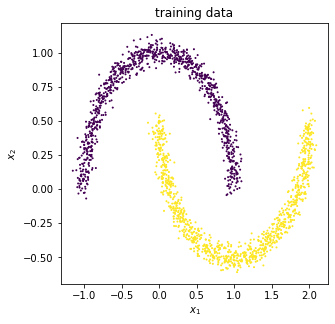

In [49]:
x,y = create_toy(tn=10, dataset='moon')
fig = plt.figure(figsize = (4.8, 4.8))
plt.scatter(*x.T,c=y,s=1)
plt.title("training data")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.show()

### Task 0: Implementation of $s$ and $t$

Recall that in the affine coupling layer, $s$ and $t$ is typically parameterized by neural network. We define a simple Multilayer Perceptron (MLP) for you below to use for $s$ and $t$. [wiki_mlp](https://en.wikipedia.org/wiki/Multilayer_perceptron) You must run this cell.


In [50]:
class MLP(nn.Module):

    # Multi Layer Perceptron to parameterize s and t
    def __init__(self, n_hidden, hidden_dim, input_dim, output_dim):
        super().__init__()
        
        # Define the layers and activation functions that will be used in forward function
        layers = []
        layers.append(nn.Linear(input_dim,hidden_dim))
        layers.append(nn.ReLU())
        for _ in range(n_hidden - 1):
            layers.append(nn.Linear(hidden_dim,hidden_dim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim,output_dim))
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        # Transform the input x 
        # expected input shape - [N, input_dim] where N is the number of samples
        # expected output shape - [N, output_dim]
        
        return self.layers(x)

### Task 1: Implementation of affine coupling layer (30/100)

In this task, you should implement the affine coupling layer which is the basic building block of RealNVP. 

Additionally, we can use a binary mask $b$ to implement partitioning (i.e., which variables are fixed and which are transformed). Note that the binary mask should be the same shape as one sample.
This is an implementation choice and is not technically required by the theoretic structure of RealNVP.
In particular, $b \odot x$ extracts the "fixed" coordinates of $x$ and makes others 0.  $(1-b) \odot x$ would extract the "transformed" coordinates of $x$ and make others 0. Also, note that adding these two together gives the original input, i.e., $b \odot x + (1-b) \odot x \equiv x$.
One nice property of using masks is that the vectors are always the same dimension, just some coordinates are 0s.

Given this use of the binary mask $b$, we can write the affine coupling layer formula as follows in a single equation:

$\begin{aligned}
z &= b \odot x + (1 - b) \odot (x \odot \exp(s(b \odot x)) + t(b \odot x)).
\end{aligned}$

The first part $b \odot x$ extracts the fixed dimensions, and the $(1-b) \odot$ part is dealing with the transformed dimensions. Note also that the input to $s$ and $t$ is $b \odot x$, i.e., the fixed dimensions + 0s for other dimensions.

And the inverse function can be written as:

$\begin{aligned}
x &= b \odot z + (1 - b) \odot ((z - t(b \odot z)) \odot \exp(-s(b \odot z))).
\end{aligned}$

Notice that $b \odot z \equiv b \odot x$ because these features do not change.

To help with training, it was found that $s$ should have the following form:

$\begin{aligned}
s(x \odot b) &= \alpha \cdot ReLU(f(x \odot b)) + \beta,
\end{aligned}$

where $f(\cdot)$ is an MLP, $\alpha$ is the scale coefficient, and $\beta$ is the shift coefficient. At the forward pass, $x$ represents the input data, and at the inverse pass, $x$ is the input feature.

The $t$ function can simply be an MLP.

Based on the formulas above, fill in the code below where indicated. The comments will tell you what is needed.

In [51]:
class AffineCoupling(nn.Module):

    def __init__(self, mask, n_hidden, hidden_dim, input_dim, output_dim):
        super().__init__()

        self.mask = nn.Parameter(mask, requires_grad = False)

        # two learnable parameters that help the training of the model
        self.alpha = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.beta = nn.Parameter(torch.zeros(1), requires_grad=True)

        # create two MLPs that will be used to parameterized s_net and t_net
        ###########################   <YOUR CODE>  ############################
        self.s_net = MLP(n_hidden, hidden_dim, input_dim, output_dim)
        self.t_net = MLP(n_hidden, hidden_dim, input_dim, output_dim)
        
        ###########################   <YOUR CODE>  ############################

    def forward(self, x):

        # Recommended implementation (self.mask will determine which features 
        #  are fixed and which are transformed)
        # Step 1: Compute s and t from fixed features.
        # Step 2: Compute transformed features based on outputs of s and t.
        # Step 3: Compute the log determinant of Jacobian

        ###########################   <YOUR CODE>  ############################
        z = x
        zm = self.mask * z
        s = self.s_net(zm)
        s = self.alpha*F.relu(s)+self.beta
        s = s*(1-self.mask)
        t = self.t_net(zm)
        z = zm + (1 - self.mask) * (x * torch.exp(s) + t)
        logdet = s.sum(dim=1)
        return z, logdet

        ###########################   <YOUR CODE>  ############################

        return z, logdet
    
    def inverse(self, z):

        # Recommended implementation
        # Step 1: Compute s and t.
        # Step 2: Compute output using inverse of f.
        # (No log determinant needed for inverse)

        ###########################   <YOUR CODE>  ############################
        x = z
        xm = x*self.mask*1.0
        s = self.s_net(xm)
        s = self.alpha*F.relu(s)+self.beta
        s = s*(1-self.mask)
        t = self.t_net(xm)
        x = (1 - self.mask) * (z - t) * torch.exp(-s) + xm
        return x
        
        ###########################   <YOUR CODE>  ############################
        return x


# Check of the implementation
# Suppose the input is $x$, the forward process is $f$, the backward process is $f^{-1}$. We expect $x=f^{-1}(f(x))$.
def check_invertibility(model):
  x_input = torch.randn((100, 2))

  z, _ = model(x_input)
  inverse_x = model.inverse(z)

  difference = abs((inverse_x - x_input).sum())
  print(f"Passed the invertibility check {difference:g}" if difference < 1e-5 else "Did Not Pass, the difference {:f} is large".format(difference))

check_invertibility(AffineCoupling(nn.Parameter(torch.Tensor([1.0, 0.0]), requires_grad = False), 1, 16, 2, 2))

Passed the invertibility check 9.31323e-09


### Task 2: Implementation of RealNVP (30/100)

Now define the final RealNVP model by stacking affine coupling layers you just defined.

In practice, only using mask $[0,1]$ or $[1,0]$ will limit the expressiveness of the model. A widely used implementation is to stack affine coupling layers with mask alternating between $[0,1]$ and $[1,0]$.

The log probability of $x$ is:

$\begin{aligned}
\log (p_{X}(x)) &= \log \left(p_{Z}(f(x)) \right) + \log \det (\mathbf{J}),
\end{aligned}$

which can be used to calculated mean negative log-likelihood as the object of optimation.


In [52]:
class NVP2D(nn.Module):

    def __init__(self, masks, n_hidden, hidden_dim, input_dim=2, output_dim=2):
        super().__init__()

        # the masks are expected to be a list containing masks [0,1] and [1,0] 
        # An example could be [[0,1],[1,0],[0,1],[1,0],...]
        self.masks = nn.ParameterList(
            [nn.Parameter(torch.Tensor(m), requires_grad = False)
            for m in masks]
        )

        # Feel free to change it if you define the AffineCoupling Layers in a different way
        # The number of affine coupling layers would be equal to the number of elements in the masks list
        self.flows = nn.ModuleList(
            [AffineCoupling(mask = mask, n_hidden=n_hidden, hidden_dim=hidden_dim, input_dim=input_dim, output_dim=input_dim)
            for mask in self.masks
             ]
        )
        self.register_buffer('base_dist_mean', torch.zeros(input_dim))
        self.register_buffer('base_dist_var', torch.ones(input_dim))
        self.base_dist = D.Normal(self.base_dist_mean, self.base_dist_var)

    def forward(self, x):

        # Return both the transformed z and the total logdet for each sample
        ###########################   <YOUR CODE>  ############################
        logdet, z = 0, x
        for module in self.flows:
            z, ld = module(z)
            logdet += ld


        ###########################   <YOUR CODE>  ############################
        return z, logdet

    def inverse(self, z):
        
        # model the transformation x = f^-1(z)
        ###########################   <YOUR CODE>  ############################
        x = z
        for module in reversed(self.flows):
            x = module.inverse(x)


        ###########################   <YOUR CODE>  ############################    
        return x

    def log_prob(self, x):
        # propagate through the flow to get z and logdet
        # compute log likelihood log(p(x)) using the the change of variable formula
        # self.base_dist.log_prob(z) can be used to compute the log likelihood of Gaussian 
        # after computing the likelihood at each feature, you can sum over the second axis
        # the output shape should be [n_samples,]
        ###########################   <YOUR CODE>  ############################
        z, logp = self.forward(x)
        return self.base_dist.log_prob(z.cpu()).sum(dim=1) + logp.cpu()
        
        ###########################   <YOUR CODE>  ############################
        
# Check invertibility
masks = [[1.0, 0.0],
         [0.0, 1.0],
         [1.0, 0.0],         
         [0.0, 1.0],]
n_hidden = 2
hidden_dim = 256
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model = NVP2D(masks, n_hidden, hidden_dim)
check_invertibility(model)

Passed the invertibility check 5.52973e-07


### Task 3: Training the model (20/100)

Now you should train the RealNVP model you just define. In specific, at each iteration, create new samples from the toy distribution (it is like sampling a batch of data from a dataset with infinite data). Then compute the loss using the mean of log likelihood returned by the model.

We have provided some basic setup here.  You should run it for at least 4000 iterations as in the code below.

In [53]:
# Define the masks, model and optimizers as needed
# feel free to change it!

masks = [[1.0, 0.0],
         [0.0, 1.0],
         [1.0, 0.0],         
         [0.0, 1.0],]
n_hidden = 2
hidden_dim = 256
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model = NVP2D(masks, n_hidden, hidden_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr = 1e-5, weight_decay=1e-5)
n_iters = 4000 

for idx in range(n_iters):
    # At each iteration, first create training data using the given function create_toy (note y is not useful here)
    # Set tn = 1
    ###########################   <YOUR CODE>  ############################
    ## sample data from the scipy moon dataset
    X, y = create_toy(1, 'moon')
    X = torch.from_numpy(X).to(torch.float32)
    X = X.to(device)

    ## calculate the negative loglikelihood of X
    loss = -model.log_prob(X).mean()
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    ###########################   <YOUR CODE>  ############################
    if (idx + 1) % 100 == 0:
        print(f"At iteration: {idx:}, loss: {loss.item():.5f}")


At iteration: 99, loss: 2.29995
At iteration: 199, loss: 2.22734
At iteration: 299, loss: 2.18297
At iteration: 399, loss: 2.16003
At iteration: 499, loss: 2.13653
At iteration: 599, loss: 2.10913
At iteration: 699, loss: 2.07608
At iteration: 799, loss: 2.03569
At iteration: 899, loss: 1.98402
At iteration: 999, loss: 1.91825
At iteration: 1099, loss: 1.84077
At iteration: 1199, loss: 1.74977
At iteration: 1299, loss: 1.62470
At iteration: 1399, loss: 1.49085
At iteration: 1499, loss: 1.36347
At iteration: 1599, loss: 1.24383
At iteration: 1699, loss: 1.13410
At iteration: 1799, loss: 1.03607
At iteration: 1899, loss: 0.95524
At iteration: 1999, loss: 0.88992
At iteration: 2099, loss: 0.83883
At iteration: 2199, loss: 0.79684
At iteration: 2299, loss: 0.75927
At iteration: 2399, loss: 0.72452
At iteration: 2499, loss: 0.68983
At iteration: 2599, loss: 0.65901
At iteration: 2699, loss: 0.63263
At iteration: 2799, loss: 0.60866
At iteration: 2899, loss: 0.58666
At iteration: 2999, loss:

### Task 4: Evaluation (20/100)

Implement three simple functions (only one line is required for each): 

1. One function to transform the data to the latent space
2. One function to map the latent back to the data space
3. One function to compute the likelihood value (note NOT the log likelihood but the actual likelihood for plotting the density).

In [54]:
def data2latent(x):
  model.cpu()
  ###########################   <YOUR CODE>  ############################
  z, logdet = model(x)
  



  ###########################   <YOUR CODE>  ############################
  return z

def latent2data(z):
  model.cpu()
  ###########################   <YOUR CODE>  ############################
  x = model.inverse(z)
  



  ###########################   <YOUR CODE>  ############################
  return x

def get_likelihood(x):
  model.cpu()
  ###########################   <YOUR CODE>  ############################
  l = model.log_prob(x)
  l = torch.exp(l)
  


  
  ###########################   <YOUR CODE>  ############################
  return l

The following code will evaluate your trained model and your functions above. For simplicity, we have implemented these parts to help you focus on the fundamentals of normalizing flows.

**Part 1**: Transform the data to the latent space.  If the model fits the data distribution perfectly, this should look like a standard normal distribution. In general, the model will not fit the data distribution perfectly, so it will not look like exactly like a normal distribution but should have the mass concentrated near the middle.

**Part 2**: Generate new "fake" data.  First sample from the normal distribution and then pass through the inverse of your flow model.  This is like the reverse of the previous step. If the model is perfect (which it never is), the generated data will look like the original toy data.

**Part 3**: Density estimation.
First, create a density heat map using the `xline` and `yline` given (which are tensors representing the x, y coordinate). In specific, you should compute the likelihood at each point correponding to those coordinates.

You can use [torch.meshgrid](https://pytorch.org/docs/stable/generated/torch.meshgrid.html) to make the meshgrid, and [contourf](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contourf.html) to plot the contour.

Second, test the outliers. Choose 11 points from -1 to 1, i.e. -1.0, -0.8, -0.6, ... , 0.8, 1.0. Then compute the likelihood (not log likelihood) and decide whether it is an outlier by checking whether $p(x)<0.01$.


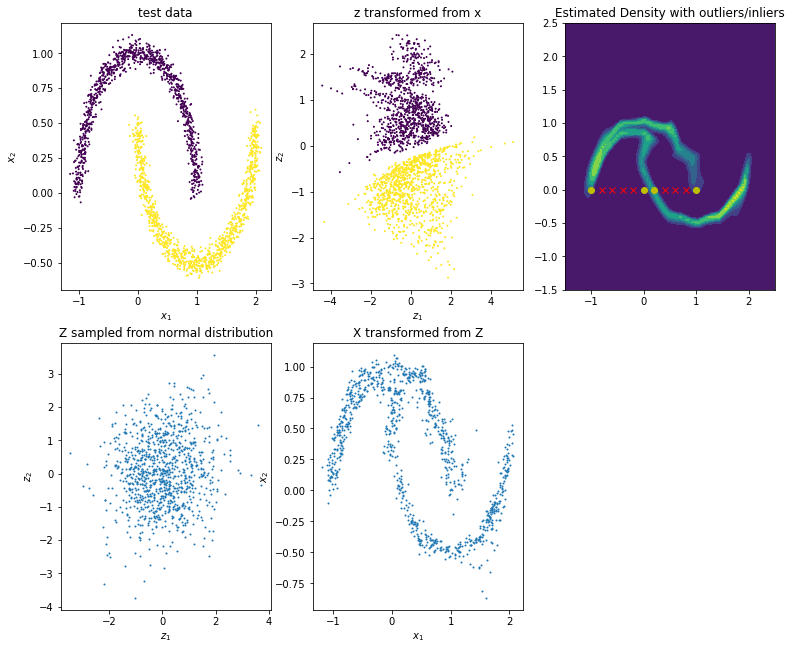

at (-1.0,0.0), the likelihood is 0.5485020876 and whether it is an outlier? - False
at (-0.8,0.0), the likelihood is 0.0000001899 and whether it is an outlier? - True
at (-0.6,0.0), the likelihood is 0.0000000004 and whether it is an outlier? - True
at (-0.4,0.0), the likelihood is 0.0000000002 and whether it is an outlier? - True
at (-0.2,0.0), the likelihood is 0.0000001563 and whether it is an outlier? - True
at (-0.0,0.0), the likelihood is 0.0140819056 and whether it is an outlier? - False
at (0.2,0.0), the likelihood is 0.7698847651 and whether it is an outlier? - False
at (0.4,0.0), the likelihood is 0.0000331485 and whether it is an outlier? - True
at (0.6,0.0), the likelihood is 0.0000034476 and whether it is an outlier? - True
at (0.8,0.0), the likelihood is 0.0057720449 and whether it is an outlier? - True
at (1.0,0.0), the likelihood is 0.3027116954 and whether it is an outlier? - False


In [55]:
# test if f can transform from x to z
# create two scatter plots, the first is the original test data x as provided
# the second is the generated z
# visualize the class label in the scatter plot as given in the previous example
# for z, you should expect seeing something like a standard normal distribution

x_test,y_test = create_toy(tn=10, dataset='moon')
x = torch.Tensor(x_test).cpu()

z = data2latent(x)

z = z.cpu().detach().numpy()

fig = plt.figure(2, figsize = (12.8, 10.8))
fig.clf()
plt.subplot(2,3,1)
plt.scatter(*x.cpu().T,c=y_test,s=1)
plt.title("test data")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")

plt.subplot(2,3,2)
plt.scatter(*z.T, c=y_test, s=1)
plt.title("z transformed from x")
plt.xlabel(r"$z_1$")
plt.ylabel(r"$z_2$")


# test if inverse of f can transform from z to x
# create two scatter plots, the first is sampled from the standard gaussian distribution as provided
# the second is the generated x transformed from z via inverse of f
# visualize the class label in the scatter plot
# from new data, you should expect to see something like the original moon

z = torch.normal(0, 1, size = (1000, 2)).cpu()

X = latent2data(z)

X = X.cpu().detach().numpy()
z = z.cpu().detach().numpy()


plt.subplot(2,3,4)
plt.scatter(*z.T,s=1)
plt.title("Z sampled from normal distribution")
plt.xlabel(r"$z_1$")
plt.ylabel(r"$z_2$")

plt.subplot(2,3,5)
plt.scatter(*X.T,s=1)
plt.title("X transformed from Z")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")


# create the density heat map using log likelihood on a meshgrid generated by 100 points
# from -1.5 to 2.5 in both dimension (10000 points in total)
xline = torch.linspace(-1.5,2.5,100)
yline = torch.linspace(-1.5,2.5,100)
xgrid, ygrid = torch.meshgrid(xline, yline)
xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

with torch.no_grad():
    zgrid = get_likelihood(xyinput).reshape(100, 100)

plt.subplot(2,3,3)
plt.contourf(xgrid.cpu().numpy(), ygrid.cpu().numpy(), zgrid.cpu().numpy())
plt.title('Estimated Density with outliers/inliers')

#---------------------------------------------------------------------#
xcor = torch.linspace(-1,1,11).view(-1,1)
ycor = torch.zeros_like(xcor).view(-1,1)
x = torch.cat((xcor,ycor),dim=-1)

# compute the likelihood at each point and decide whether it is an outlier
prob = get_likelihood(x)
plt.plot(*x[prob<0.01].T, 'rx')
plt.plot(*x[prob>=0.01].T, 'yo')
plt.show()

for i in range(x.shape[0]):
    print('at ({:.1f},{}), the likelihood is {:.10f} and whether it is an outlier? - {}'.format(x[i,0].item(),x[i,1].item(),prob[i].item(), prob[i]<0.01))

## (Optional, ungraded) Exercise 2: MAF for 2D data


An autoregressive model predicts future behavior on past behavior and can be used to predict the sequential data. For example, given sequential data $\mathbf{x} = [x_1, \cdots, x_D]$, the joint distribution will be modeled as below

$p(\mathbf{x})=\prod_{i=1}^{D} p\left(x_{i} \mid x_{1}, \ldots, x_{i-1}\right)=\prod_{i=1}^{D} p\left(x_{i} \mid x_{1: i-1}\right)$

An autoregressive flow is a flow model that is composed as a autoregressive model.

MAF represents Masked Autoregressive Flow. Given known distributions $p(z)$, MAF models $p(x)$ assuming that $x_i$ is dependent on $x_{1:i-1}$.

In specific (the notation follows from the paper [1705.07057.pdf (arxiv.org)](https://arxiv.org/pdf/1705.07057.pdf)), 

$\mathbf{x}_{i}=\mathbf{z}_{i} \odot \exp(\alpha_{i}\left(\mathbf{x}_{1: i-1}\right))+\mu_{i}\left(\mathbf{x}_{1: i-1}\right)$

where $\sigma_i$ and $\mu_i$ are parameterized by neural networks. In MAF, they are typically parameterized by Masked Autoencoder for Distribution Estimation (MADE).
Figure 1 in the paper ([MADE: Masked Autoencoder for Distribution Estimation (arxiv.org)](https://arxiv.org/pdf/1502.03509.pdf)) is a great example and will be referred to below.
The key to MADE is that the inputs can only affect "downstream" outputs of this neural network, which ensures the autoregressive property that is required, e.g., $x_5$ cannot affect the 3rd output $\alpha_3$ but it can affect the 7th output $\alpha_7$. More formally, this means $\alpha_i = f_i(x_1, x_2, \cdots, x_{i-1})$ and similarly for $\mu_i$.

The left network computes as (notation from paper [MADE: Masked Autoencoder for Distribution Estimation (arxiv.org)](https://arxiv.org/pdf/1502.03509.pdf))

$\begin{aligned}
\mathbf{h}^{l} &=\operatorname{activation}^{l}\left(\mathbf{W}^{l} \mathbf{h}^{l-1}+\mathbf{b}^{l}\right) \\
\hat{\mathbf{x}} &=\sigma\left(\mathbf{V h}^{L}+\mathbf{c}\right)
\end{aligned}$

The right network computes as 

$\begin{aligned}
\mathbf{h}^{l} &=\text { activation }^{l}\left(\left(\mathbf{W}^{l} \odot \mathbf{M}^{\mathbf{W}^{l}}\right) \mathbf{h}^{l-1}+\mathbf{b}^{l}\right) \\
\hat{\mathbf{x}} &=\sigma\left(\left(\mathbf{V} \odot \mathbf{M}^{V}\right) \mathbf{h}^{L}+\mathbf{c}\right)
\end{aligned}$

Each node is randomly assigned an integer between $1$ and $D-1$ represented as $m_k^l$. For example, in the plot above, the 3rd node(k=3) at the 1st layer(l=1) $m_3^1=2$. The binary mask $\mathbf{M}$ is defined as below

$\begin{aligned}
&M_{k^{\prime}, k}^{\mathbf{W}^{l}}=\mathbf{1}_{m_{k^{\prime}}^{l} \geq m_{k}^{l-1}}= \begin{cases}1, & \text { if } m_{k^{\prime}}^{l} \geq m_{k}^{l-1} \\
0, & \text { otherwise }\end{cases} \\
&M_{d, k}^{\mathbf{V}}=\mathbf{1}_{d \geq m_{k}^{L}}= \begin{cases}1, & \text { if } d>m_{k}^{L} \\
0, & \text { otherwise }\end{cases}
\end{aligned}$

The weight is non-zero only if the integer assigned to its corresponding unit is larger than the the integer assigned to its previous unit. To make sure that all hidden units are connected to at least one input and output, we should make sure $m_k^l \geq \min_{k^{\prime}} m_{k^{\prime}}^{l-1}$.

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn import datasets

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.distributions as D
import torchvision.transforms as T


In [ ]:
def create_toy(tn, dataset):

    # tn - controlling the number of samples
    rng = 0

    if dataset == 'moon': 
        X, y = datasets.make_moons(n_samples = int(200*tn) , noise = 0.05, random_state=rng)

    elif dataset == 'checkerboard':
        x1 = np.random.rand(int(200*tn)) * 4 - 2
        x2_ = np.random.rand(int(200*tn)) - np.random.randint(0, 2, int(200*tn)) * 2
        x2 = x2_ + (np.floor(x1) % 2)
        X = np.concatenate([x1[:, None], x2[:, None]], 1) * 2
        y = None

    return X, y

### Task 1: Implementation of MADE

The code for creating masks and masked linear has already been provided.

**Note:** MADE is not an invertible flow model. For simplicity, we implement it as an invertible model by incorporating it with affine transformation.

In [ ]:
def create_masks(input_size, hidden_size, n_hidden, input_degrees=None):

    # first assign degrees to each node 
    # create mask i.e. whether the corresponding w in the linear layers will be used
    # the mask should be a list of tensors that is in the same shape of weight matrix in the linear layer to be used
    # return the mask list and the tensor corresponding to the degrees of input nodes (in the shape of [input_dim,])
    degrees = []

    degrees += [torch.arange(input_size)] if input_degrees is None else [input_degrees]
    for _ in range(n_hidden + 1):
        degrees += [torch.arange(hidden_size) % (input_size - 1)]
    degrees += [torch.arange(input_size) % input_size - 1] if input_degrees is None else [input_degrees % input_size - 1]

    # construct masks
    masks = []
    for (d0, d1) in zip(degrees[:-1], degrees[1:]):
        masks += [(d1.unsqueeze(-1) >= d0.unsqueeze(0)).float()]

    return masks, degrees[0]

class MaskedLinear(nn.Linear):
    #MADE building block layer
    
    def __init__(self, input_size, n_outputs, mask):
        super().__init__(input_size, n_outputs)

        self.register_buffer('mask', mask)

    def forward(self, x):
        out = F.linear(x, self.weight * self.mask, self.bias)
        return out

In [ ]:
class MADE(nn.Module):
    def __init__(self, input_size, hidden_size, n_hidden, input_degrees=None):

        super().__init__()

        # create the masks 
        # remember to swap the degree of the input nodes by assigning input_degrees
        ###########################   <YOUR CODE>  ############################
        
        



        ###########################   <YOUR CODE>  ############################

        # construct the model using a few MaskedLinear layers
        # the basic structure would be same as constructing a fully connected layer using nn.Linear and nn.Sequential
        # remember to add activation function such as Tanh() after each layer except the last layer
        self.net_input = MaskedLinear(input_size, hidden_size, masks[0])
        activation_fn = nn.Tanh()
        self.net = []
        for m in masks[1:-1]:
            self.net += [activation_fn, MaskedLinear(hidden_size, hidden_size, m)]
        self.net += [activation_fn, MaskedLinear(hidden_size, 2 * input_size, masks[-1].repeat(2,1))]
        self.net = nn.Sequential(*self.net)

    def forward(self, x):
        # first generate mu and alpha using the network you define above
        # compute z using z = (x-mu) * exp(-alpha)
        # compute the log determinant of Jacobian
        # return z and log determinant of Jacobian
        ###########################   <YOUR CODE>  ############################
        
        


        
        ###########################   <YOUR CODE>  ############################
        return z, logdet

    def inverse(self, z):
        # inverse propagation
        x = torch.zeros_like(z)
        for i in self.input_degrees:
            mu, loga = self.net(self.net_input(x)).chunk(chunks=2, dim=1)
            x[:,i] = z[:,i] * torch.exp(loga[:,i]) + mu[:,i]
        return x


### Task 2: Implementation of MAF

Define the MAF model.

In this task, while stacking MADE to construct MAF, alternate the degree of two input dimension. In specific, set them to be $[0,1] $ and $[1,0]$ alternatively.

In [ ]:

class MAF2D(nn.Module):
    def __init__(self, n_blocks, input_size, hidden_size, n_hidden, flip=True):
        super().__init__()
        """
        n_blocks - number of MADE 
        input_size - input dimension
        hidden_size - hidden dimension of MADE
        n_hidden - number of hidden layers in each MADE
        flip - whether to flip the degree of input dimension in each MADE
        """
        # base distribution for calculation of log prob under the model
        # can be used by calling self.base_dist.log_prob(z)
        self.register_buffer('base_dist_mean', torch.zeros(input_size))
        self.register_buffer('base_dist_var', torch.ones(input_size))
        self.base_dist = D.Normal(self.base_dist_mean, self.base_dist_var)

        # construct model
        flows = []
        
        for i in range(n_blocks):
            
            if flip:
                if i%2 == 0:
                    input_degrees = torch.LongTensor([0,1])
                else: 
                    input_degrees = torch.LongTensor([1,0])
            else:
                input_degrees = None

            flows += [MADE(input_size, hidden_size, n_hidden, input_degrees = input_degrees)]

        self.flows = nn.ModuleList(flows)

    def forward(self, x):
        # model the transformation z = f(x)
        # propagate through the flow defined above
        # remember to keep track of the log Jacobian determinant 
        ###########################   <YOUR CODE>  ############################
        
        




        ###########################   <YOUR CODE>  ############################

    def inverse(self, z):
        # model the transformation x = f^{-1}(z)
        # propagate through the inverse of the flow
        ###########################   <YOUR CODE>  ############################
        
        




        ###########################   <YOUR CODE>  ############################

    def log_prob(self, x):
        # propagate through the flow to get z
        # compute log likelihood p(x) using the the change of variable formula
        # self.base_dist.log_prob(z) can be used to compute the log likelihood of Gaussian 
        ###########################   <YOUR CODE>  ############################
        
        



        
        ###########################   <YOUR CODE>  ############################

### Task 3: Training the model
Follow the same step as Exericise 1.

In [ ]:
x,y = create_toy(tn=10, dataset='moon')
fig = plt.figure(figsize = (4.8, 4.8))
plt.scatter(*x.T,c=y,s=1)
plt.title("training data")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.show()

Training and testing using **moon** data.

In [ ]:
# define the MAF model
# define the optimizer and n_iters as needed 
# feel free to change it!

n_blocks = 8
hidden_dim = 48
input_size = 2
n_hidden = 2

model = MAF2D(n_blocks=n_blocks, input_size=2, hidden_size=hidden_dim, n_hidden=n_hidden)
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr = 1e-4, weight_decay=1e-5)
n_iters = 2000


for idx in range(n_iters):

    # generative new 200 samples at each iteration using create_toy with tn=1
    # compute the loss and backpropagate
    # print out the loss after each 100 iterations
    ###########################   <YOUR CODE>  ############################
    
    




    
    ###########################   <YOUR CODE>  ############################
    if (idx + 1) % 100 == 0:
        print(f"idx_steps: {idx:}, loss: {loss.item():.5f}")
        


### Task 4: Evaluation.
Follow the same three steps as Exercise 1.

In [ ]:
# test if f can transform from x to z
# create two scatter plots, the first is the original test data x
# the second is the generated z
# visualize the class label in the scatter plot

x_test,y_test = create_toy(tn=10, dataset='moon')
###########################   <YOUR CODE>  ############################





###########################   <YOUR CODE>  ############################

fig = plt.figure(2, figsize = (12.8, 4.8))
fig.clf()
plt.subplot(1,2,1)
plt.scatter(*x.cpu().T,c=y_test,s=1)
plt.title("test data")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")

plt.subplot(1,2,2)
plt.scatter(*z.T, c=y_test, s=1)
plt.title("z transformed from x")
plt.xlabel(r"$z_1$")
plt.ylabel(r"$z_2$")
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.show()


In [ ]:
# test if inverse of f can transform from z to x
# create two scatter plots, the first is sampled from the standard gaussian distribution
# the second is the generated z
# visualize the class label in the scatter plot

###########################   <YOUR CODE>  ############################






###########################   <YOUR CODE>  ############################

fig = plt.figure(2, figsize = (12.8, 4.8))
fig.clf()
plt.subplot(1,2,1)
plt.scatter(*z.T,s=1)
plt.title("Z sampled from normal distribution")
plt.xlabel(r"$z_1$")
plt.ylabel(r"$z_2$")

plt.subplot(1,2,2)
plt.scatter(*X.T,s=1)
plt.title("X transformed from Z")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
# plt.xlim(-3,3)
# plt.ylim(-3,3)
plt.show()

In [ ]:
# create the density heat map using log likelihood on a meshgrid generated by 100 points
# from -1.5 to 2.5 in both dimension (10000 points in total)
xline = torch.linspace(-1.5,2.5,100)
yline = torch.linspace(-1.5,2.5,100)
xgrid, ygrid = torch.meshgrid(xline, yline)
xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

with torch.no_grad():
    zgrid = model.cpu().log_prob(xyinput).exp().reshape(100, 100)

plt.contourf(xgrid.cpu().numpy(), ygrid.cpu().numpy(), zgrid.cpu().numpy())
plt.show()